# Suggestion to Reader: Scroll to Bottom _First_

There's one cell that wraps everything together in a concise, functional demo.

In [70]:
# %matplotlib notebook

import cv2
import pykitti
import numpy as np
from matplotlib import pyplot as plt

kitti_dir = 'kitti'
kitti_sequence = '04'

kitti = pykitti.odometry(kitti_dir, kitti_sequence)

## Detect Features

In [71]:
def detect_matches_and_E(img1, img2, draw=True):
	# Find Matches
	# From: https://stackoverflow.com/a/33670318
	sift = cv2.SIFT_create()
	kp1, des1 = sift.detectAndCompute(img1, None)
	kp2, des2 = sift.detectAndCompute(img2, None)
	bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
	matches = bf.match(des1, des2)
	matches = sorted(matches, key=lambda x: x.distance)

	if draw:
		match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
		plt.figure(figsize=(9, 3))
		plt.imshow(match_img)
		plt.show()

	# Find Points
	# From book
	imgpts1 = []
	imgpts2 = []
	for match in matches:
		imgpts1.append(kp1[match.queryIdx].pt)
		imgpts2.append(kp2[match.trainIdx].pt)
	
	points1 = np.array(imgpts1)
	points2 = np.array(imgpts2)
	
	F, status_mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, 0.1, 0.99, 100000)
	E = K.T @ F @ K
	
	if draw:
		print(f"Keeping {np.sum(status_mask)}/{status_mask.size} points that match the fundamental matrix")

	status_mask = status_mask[:, 0] == 1
	points1 = points1[status_mask]
	points2 = points2[status_mask]

	return points1, points2, matches, E


In [72]:
# From book
def P_from_E(E):
	# ???: It seems like all the data here is in w, which we
	w, u, vt = cv2.SVDecomp(E)

	W = np.array([
		[0, -1 , 0],
		[1, 0, 0],
		[0, 0, 1]
	])

	R = u @ W @ vt
	t = u[:, 2]

	assert np.abs(np.linalg.det(R)) - 1.0 <= 1e-07, "det(R) != ±1.0, this isn't a rotation matrix!"

	P = np.hstack((R, t[:, np.newaxis]))
	return P

## Triangulation

In [73]:
# From book
def triangulate(
	# NOTE: u and u1 need to be normalized (multiplied by K, or P0 and P1 do)
	u0: np.array, # point in image 1: (x, y, 1)
	P0: np.array, # camera 1 matrix
	u1: np.array, # point in image 2: (x, y, 1)
	P1: np.array, # camera 2 matrix
):
	# XXX: I don't quite understand this
	A = np.array([
		[u0[0]*P0[2,0]-P0[0,0], u0[0]*P0[2,1]-P0[0,1], u0[0]*P0[2,2]-P0[0,2]],
		[u0[1]*P0[2,0]-P0[1,0], u0[1]*P0[2,1]-P0[1,1], u0[1]*P0[2,2]-P0[1,2]],
		[u1[0]*P1[2,0]-P1[0,0], u1[0]*P1[2,1]-P1[0,1], u1[0]*P1[2,2]-P1[0,2]],
		[u1[1]*P1[2,0]-P1[1,0], u1[1]*P1[2,1]-P1[1,1], u1[1]*P1[2,2]-P1[1,2]]
	])

	B = np.array([
		-(u0[0]*P0[2, 3]-P0[0, 3]),
		-(u0[1]*P0[2, 3]-P0[1, 3]),
		-(u1[0]*P1[2, 3]-P1[0, 3]),
		-(u1[1]*P1[2, 3]-P1[1, 3])
	])

	_, X = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
	return np.array([*X[:, 0], 1.0])


In [74]:
from collections import namedtuple

class CloudPoint(namedtuple('CloudPoint', ['point_3d', 'point_2d_2'])):
	def __eq__(self, other):
		return np.array_equal(self.point_3d, other.point_3d) and np.array_equal(self.point_2d_2, other.point_2d_2)

# From book
def triangulate_points(
	pt_set1: np.array,
	pt_set2: np.array,
	K: np.array,
	P0: np.array,
	P1: np.array,
):
	Kinv = np.linalg.inv(K)
	point_cloud = []
	reproj_error = []
	
	for i in range(len(pt_set1)):
		# Convert to normalized, homogeneous coordinates
		u0 = Kinv @ np.array([*pt_set1[i], 1.0])
		u1 = Kinv @ np.array([*pt_set2[i], 1.0])

		# Triangulate
		X = triangulate(u0, P0, u1, P1)
		cloudpoint = CloudPoint(X[0:3], pt_set2[i])

		if cloudpoint in point_cloud:
			continue

		# Calculate reprojection error
		reproj = K @ P1 @ X
		reproj_normalized = reproj[0:1] / reproj[2]
		reproj_error.append(np.linalg.norm(reproj_normalized))
		point_cloud.append(cloudpoint)
	
	# Return mean reprojection error
	return np.mean(reproj_error), point_cloud


In [75]:
def P_from_PnP(point_cloud, points2, K):
	# Not really from book, because the book's implementation of this is incomprehensible
	success, rvec, t, inliers = cv2.solvePnPRansac(np.array([p.point_3d for p in point_cloud]), points2, K, None)
	assert success, "PnP failed!"

	R, _ = cv2.Rodrigues(rvec)

	P = np.hstack((R, t))
	return P, R, t

In [76]:
# Helper
def normalize(v, *args, **kwargs):
    return v / np.linalg.norm(v, *args, **kwargs)

## Continuous

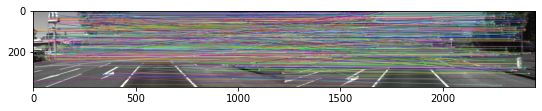

Keeping 558/1481 points that match the fundamental matrix
Keeping 214/550 new points, others weren't present in previous frame.
[[-9.99686988e-01 -8.81748178e-04  2.50029811e-02  1.35339020e-02]
 [ 6.67649850e-04 -9.99963054e-01 -8.56996745e-03 -4.12765977e-03]
 [ 2.50096139e-02 -8.55059171e-03  9.99650642e-01  9.74054393e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Mean reprojection error: 533.9320265994398
Keeping 217/566 new points, others weren't present in previous frame.
[[-9.98006510e-01  2.57195476e-05  6.31110528e-02  3.29964730e-02]
 [-2.38687396e-04 -9.99994303e-01 -3.36695658e-03  1.79819654e-04]
 [ 6.31106067e-02 -3.37530840e-03  9.98000831e-01  9.47585340e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-9.99686988e-01 -8.81748178e-04  2.50029811e-02  1.35339020e-02]
 [ 6.67649850e-04 -9.99963054e-01 -8.56996745e-03 -4.12765977e-03]
 [ 2.50096139e-02 -8.55059171e-03  9.99650

In [77]:
# I made this part up, although it's an amalgamation of code from above which came from other places
# This cell is self-contained from a state perspective, but not a logic one
from itertools import islice

### Setup ###
K = kitti.calib.K_cam0
imgs = (np.array(img) for img in kitti.cam0)
ground_truth_poses = kitti.poses

img0 = next(imgs)
img1 = next(imgs)

points0, points1, matches, E = detect_matches_and_E(img0, img1)
# P0 is assumed to be fixed to start
P0 = np.array([
	[1, 0, 0, 0],
	[0, 1, 0, 0],
	[0, 0, 1, 0]
])
P1 = P_from_E(E)
Ps = [P0, P1]
Es = [E]
cur_pose = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
poses = [cur_pose]
err, point_cloud = triangulate_points(points0, points1, K, P0, P1)




### Graph ###
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# for cp in point_cloud:
# 	ax.scatter(*cp.point_3d)

# ax.set_title('First Round 3D Points')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()

### Run ###

for img in islice(imgs, 20):
	img0, img1 = img1, img
	points0, points1, matches, E = detect_matches_and_E(img0, img1, draw=False)
	Es.append(E)
	points1_valid = []

	for point0, point1 in zip(points0, points1):
		for cp in point_cloud:
			if np.array_equal(point0, cp.point_2d_2):
				points1_valid.append((cp, point1))
				break
	
	print(f"Keeping {len(points1_valid)}/{len(points1)} new points, others weren't present in previous frame.")

	P0 = P1
	P1, R, t = P_from_PnP((cp for cp, _ in points1_valid), np.array([point1 for cp, point1 in points1_valid]), K)
	Ps.append(P1)
	P1_fixed = np.vstack((P1, [0,0,0,1]))
	print(P1_fixed, cur_pose)
	cur_pose = (P1_fixed @ cur_pose)
	poses.append(cur_pose)

	err, point_cloud = triangulate_points(points0, points1, K, P0, P1)
	print("Mean reprojection error:", err)


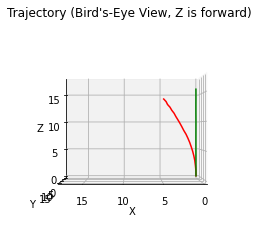

In [78]:
def plot_trajectory(ax, poses, scale_factor=1.0, line_color='r', arrow_color='b', arrow_size=5, arrow_prop=5):
    XYZ = np.array([P @ np.array([[0,0,0,1]]).transpose() for P in poses]).squeeze(axis=2)
    UVW = np.array([normalize(P @ np.array([[0,0,1,1]]).transpose()) * arrow_size for P in poses]).squeeze(axis=2)
    
    XYZ *= scale_factor
    UVW *= scale_factor

    MIN = 0
    MAX = np.max([np.max(XYZ), *ax.get_xlim(), *ax.get_ylim(), *ax.get_zlim()]) * 1.10

#     ax.quiver(
#         XYZ[::arrow_prop, 0], XYZ[::arrow_prop, 1], XYZ[::arrow_prop, 2],
#         UVW[::arrow_prop, 0], UVW[::arrow_prop, 1], UVW[::arrow_prop, 2], color=arrow_color)
    ax.plot(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], line_color)

    ax.set_xlim(MIN, MAX)
    ax.set_ylim(MIN, MAX)
    ax.set_zlim(MIN, MAX)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
plot_trajectory(ax, poses)
plot_trajectory(ax, ground_truth_poses[:len(poses)], 0.60, 'g', 'g')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90)
ax.set_title("Trajectory (Bird's-Eye View, Z is forward)")
plt.show()